# Import libraries

In [1]:
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from eli5 import show_weights, show_prediction
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression


#custom
from helper import DataProcessing
from ml_metrics import evaluate_model, multiclass_logloss
from plotting import plot_tsne

/home/didier/anaconda3/envs/c19biohack_ml/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/didier/anaconda3/envs/c19biohack_ml/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
/home/didier/anaconda3/envs/c19biohack_ml/lib/python3.7/site-packages/tensorfl

In [2]:
# set K-mer length here
kmer = 4


In [3]:
orf1 = DataProcessing('coronavirus_orf1ab.fasta', 'coronavirus_orf1ab_meta.csv')

In [4]:
#this will take a while
# kmers = orf1.get_amino_kmer_df(4)
amino_df = orf1.get_amino_df(kmer)
print(amino_df.shape)

# get rid of duplicates
amino_df.drop_duplicates(subset='Accession', keep=False, inplace=True)
print(amino_df.shape)
amino_df.head()

(3046, 13)
(2384, 13)


,Accession,Release_Date,Species,Length,Geo_Location,Host,Isolation_Source,Collection_Date,GenBank_Title,seq_offset_0,seq_offset_1,seq_offset_2,seq_offset_3
1,YP_009555238,2019-02-21T00:00:00Z,Betacoronavirus 1,7095,USA,NaN,NaN,NaN,Orf1ab [Human coronavirus OC43],MSKINKYGLELHWAPEFPWMFEDAEEKLDNPSSSEVDMICSTTAQK...,SKINKYGLELHWAPEFPWMFEDAEEKLDNPSSSEVDMICSTTAQKL...,KINKYGLELHWAPEFPWMFEDAEEKLDNPSSSEVDMICSTTAQKLE...,INKYGLELHWAPEFPWMFEDAEEKLDNPSSSEVDMICSTTAQKLET...
2,YP_002308478,2018-08-24T00:00:00Z,Bulbul coronavirus HKU11,6264,Hong Kong,Pycnonotus jocosus,NaN,2007-01,orf1ab polyprotein [Bulbul coronavirus HKU11-934],MVKNVSKRSPIVLPQIQPPPLQLFIAVAAAEEGHPKDLKYLGNYNL...,VKNVSKRSPIVLPQIQPPPLQLFIAVAAAEEGHPKDLKYLGNYNLV...,KNVSKRSPIVLPQIQPPPLQLFIAVAAAEEGHPKDLKYLGNYNLVT...,NVSKRSPIVLPQIQPPPLQLFIAVAAAEEGHPKDLKYLGNYNLVTS...
3,YP_009513008,2018-08-24T00:00:00Z,Hedgehog coronavirus 1,7150,Germany,Erinaceus europaeus,feces,2012,orf1ab [Betacoronavirus Erinaceus/VMC/DEU/2012],MSSATGEGSQGARATYRAALNNEKRHDHVALTVPCCGTEAKVTALS...,SSATGEGSQGARATYRAALNNEKRHDHVALTVPCCGTEAKVTALSP...,SATGEGSQGARATYRAALNNEKRHDHVALTVPCCGTEAKVTALSPW...,ATGEGSQGARATYRAALNNEKRHDHVALTVPCCGTEAKVTALSPWF...
4,YP_009513020,2018-08-24T00:00:00Z,Coronavirus HKU15,6267,China: Hong Kong,Sus scrofa,NaN,2010,replicase polyprotein [Porcine coronavirus HKU15],MAKNKSKRDAIALPENVPPPLQLFIHVAAAEEGHPKVTTYLGNYNL...,AKNKSKRDAIALPENVPPPLQLFIHVAAAEEGHPKVTTYLGNYNLY...,KNKSKRDAIALPENVPPPLQLFIHVAAAEEGHPKVTTYLGNYNLYA...,NKSKRDAIALPENVPPPLQLFIHVAAAEEGHPKVTTYLGNYNLYAT...
5,YP_009389424,2017-07-14T00:00:00Z,Wencheng Sm shrew coronavirus,6324,China,Suncus murinus,NaN,2015,ORF1ab polyprotein [Wencheng Sm shrew coronavi...,MSVSKVELFVPISDEVDATHFGTFGDAVEAYASAAPSFEGVYFVAY...,SVSKVELFVPISDEVDATHFGTFGDAVEAYASAAPSFEGVYFVAYG...,VSKVELFVPISDEVDATHFGTFGDAVEAYASAAPSFEGVYFVAYGL...,SKVELFVPISDEVDATHFGTFGDAVEAYASAAPSFEGVYFVAYGLQ...


# Split the dataframe

In [5]:
#split dataframe
mask = np.random.rand(len(amino_df)) < 0.8
train_df = amino_df[mask]
test_df = amino_df[~mask]
print(f'Size of the test df: {len(test_df)}. Size of the train df: {len(train_df)}.')

Size of the test df: 496. Size of the tain df: 1888.


In [6]:
#split
xtrain = train_df['seq_offset_0'].values
xtest = test_df['seq_offset_0'].values

# Vectorize the sequence

In [7]:
#vectorize
ctv = CountVectorizer(analyzer='char', ngram_range=(kmer, kmer), lowercase=False) # kmer: k-mer length

ctv.fit(list(xtrain)+list(xtest))
xtrain_ctv = ctv.transform(xtrain)
xtest_ctv = ctv.transform(xtest)

In [8]:
#K-means clustering
def run_kmeans(k):
    class_dict = dict(zip(range(k), [f'cluster_{i}' for i in range(k)]))
    kmeans = MiniBatchKMeans(n_clusters=k,verbose=0, batch_size=100,random_state=101)
    ytrain = kmeans.fit_predict(xtrain_ctv)
    ytest = kmeans.fit_predict(xtest_ctv)
    return ytrain, ytest, class_dict

In [9]:
%%time
error_rate = []

# Will take some time
for i in range(2,20):
    print (i, end=" ")
    ytrain, ytest, class_dict = run_kmeans(i)
    #fit logistic regression on CountVectorizer
    
    clf = LogisticRegression(C=1.0, max_iter=4000,n_jobs=-1,random_state=101)
    clf.fit(xtrain_ctv, ytrain)
    predictions = clf.predict(xtest_ctv)
    error_rate.append(np.mean(predictions != ytest))


2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 CPU times: user 54min 27s, sys: 14.9 s, total: 54min 42s
Wall time: 1h 10min 18s


Text(0, 0.5, 'Error Rate')

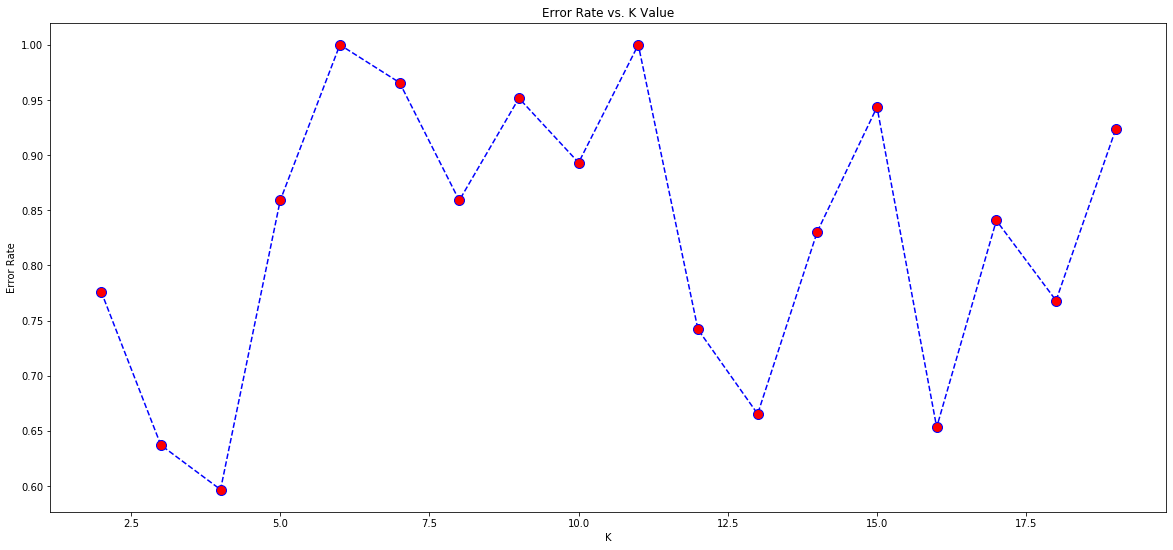

In [11]:
plt.figure(figsize=(20,9))
plt.plot(range(2,20),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
